In [1]:
import numpy as np
import math

The equation we are testing is

$$
\begin{cases}
u''(x) +u(x) = e^{-x}, \qquad\text{for}\; 0<x<1,\\
u(0) = 1,  \qquad u\left(1\right) = \frac{1}{2}\cos(1) + \frac{1}{2}\sin(1) + \frac{e^{-1}}{2}.
\end{cases}
$$ 

The exact solution is
$$ u^*(x) = \frac{\cos x+\sin x + e^{-x}}{2} $$



---

The idea of the paper is, assume $$u = \mathrm{NN}(x).$$
We minimize the loss function
$$ L(u^*, \hat{u}) = \mathrm{Mean}\left(\left\Vert \frac{d^2\hat{u}}{dx^2} + \hat{u}(x) - \Big(- e^{x}\Big)\right\Vert^2\right) + \frac{|\hat{u}(0)|^2 + |\hat{u}\left(1\right)|^2}{2}$$
where all the derivatives are computed via 
* back-propagation - we tried this idea but it does not work well, maybe autograd in Pytorch does not perform it well, or the idea behind it is problematic, in the sense that the derivative obtained by back-propagation with second-order is not very nice.
* finite difference scheme

In [2]:
# Import libraries
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [3]:
def u_star_func(x):
    result = 1/2*(np.exp(-x) + np.cos(x) + np.sin(x))
    return result

In [4]:
# Discritize the interval
a = 0
b = 1
step = (b-a)/100
x_init_np = np.arange(start=a, stop=b+step, step=step)
x_init = torch.tensor(x_init_np, requires_grad= True)

In [5]:
bb = u_star_func(1)
def Loss(u_hat, second_derivative_u_hat, x_data):
    loss = nn.MSELoss()
    result = loss(second_derivative_u_hat[1:-1] +u_hat[1:-1], torch.exp(-x_data[1:-1])) + 1/2*(torch.square(u_hat[0]-1) + torch.square(u_hat[-1]-bb))
    return result

In [6]:
input_size = 1
output_size = 1
k = 5

module1 = nn.Linear(input_size, k)
init.xavier_normal_(module1.weight)

module5 = nn.Linear(k, output_size)
init.xavier_normal_(module5.weight)

model = nn.Sequential(module1,
                      nn.Tanh(),

                      module5,
                      nn.Tanh(),

                      )
print(model)

Sequential(
  (0): Linear(in_features=1, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Tanh()
)


In [7]:
import matplotlib.pyplot as plt
def draw_result(lst_iter, lst_loss, title='Loss'):
    plt.plot(lst_iter, lst_loss, '-b', label='loss')
    
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title +".png")  # should before show method

    # show
    plt.show()

In [8]:
def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')

    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)

    # save image
    plt.savefig(title+".png")  # should before show method

    # show
    plt.show()

In [9]:
# optimizer = optim.SGD(model.parameters(), lr=0.07, momentum=3.0)
def run_train(lr = 0.001, num_e = 1000, isOn = True):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    time0 = time()
    num_e = num_e
    iter = []
    test_error_vec = []
    # print(model.parameters())
    scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.1)
    scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1)
    for e in range(num_e):
        running_loss = 0
        
        optimizer.zero_grad() # call zero_Grad
        u_hat = torch.tensor(np.array([])) 
        d2u_hat = torch.tensor(np.array([]))
        for x in x_init_np:
            x_tensor = torch.tensor(np.array([x]), requires_grad= True)
            temp = model(x_tensor.float())
            u_hat = torch.hstack([u_hat, temp])
        u_hat[0] = 1
        u_hat[-1] = bb   
        d2u_hat = u_hat.clone()    
        d2u_hat[1:-1] = (u_hat[0:-2] + u_hat[2:] - 2*u_hat[1:-1])/step**2     

        loss = Loss(u_hat,d2u_hat,x_init)
        loss.backward()
      
        optimizer.step() 


        running_loss += loss.clone().item()    
        if isOn == True:
            print(f"The running loss at {e+1} iteration is: {running_loss}")
        test_error_vec.append(running_loss)
        iter.append(e)

    draw_result(iter, test_error_vec)
    y_true = u_star_func(x_init_np)
    draw_graph(x_init_np, y_true, u_hat.clone().detach().numpy(), 'Solutions')
    print(np.mean(np.square(y_true -  u_hat.clone().detach().numpy())))

The running loss at 1 iteration is: 85156.35345967334
The running loss at 2 iteration is: 16280.942827651197
The running loss at 3 iteration is: 11413.665877208563
The running loss at 4 iteration is: 11726.34471902191
The running loss at 5 iteration is: 12416.254482392045
The running loss at 6 iteration is: 12949.921254041268
The running loss at 7 iteration is: 13312.652691614161
The running loss at 8 iteration is: 13546.665026677125
The running loss at 9 iteration is: 13687.225964270578
The running loss at 10 iteration is: 13757.272939341041
The running loss at 11 iteration is: 13770.411676486834
The running loss at 12 iteration is: 13733.467856986787
The running loss at 13 iteration is: 13648.229555173746
The running loss at 14 iteration is: 13512.102450158045
The running loss at 15 iteration is: 13318.069851627672
The running loss at 16 iteration is: 13054.001554397864
The running loss at 17 iteration is: 12701.004160650124
The running loss at 18 iteration is: 12230.844122161147
The

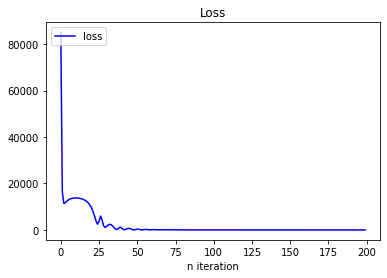

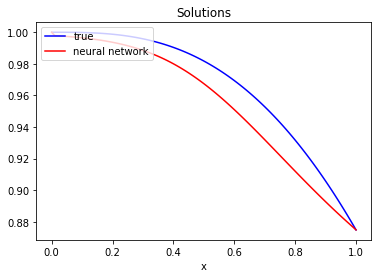

0.00017228966269093184
The running loss at 1 iteration is: 4.230279589899785
The running loss at 2 iteration is: 217.9127895815039
The running loss at 3 iteration is: 3238.9130712951883
The running loss at 4 iteration is: 6.801994739643446
The running loss at 5 iteration is: 1031.0174921311154
The running loss at 6 iteration is: 1994.7646625886464
The running loss at 7 iteration is: 1947.4740059564956
The running loss at 8 iteration is: 1160.5196675967773
The running loss at 9 iteration is: 238.9292642595031
The running loss at 10 iteration is: 91.70214518775292
The running loss at 11 iteration is: 926.3066000061318
The running loss at 12 iteration is: 1047.706445945474
The running loss at 13 iteration is: 316.0991044749299
The running loss at 14 iteration is: 3.235243396560528
The running loss at 15 iteration is: 250.04746021344985
The running loss at 16 iteration is: 562.4475322321706
The running loss at 17 iteration is: 629.6269226530391
The running loss at 18 iteration is: 428.4436

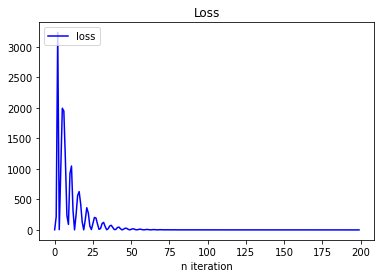

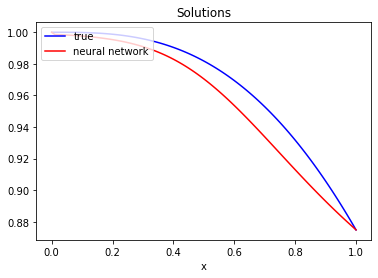

0.00013415150345517858


In [10]:
run_train(lr=0.1, num_e= 200)
run_train(lr=0.05, num_e= 200)
# run_train(lr=0.0001, num_e= 1000)

The running loss at 1 iteration is: 1.8368460363064958
The running loss at 2 iteration is: 20.23802618941624
The running loss at 3 iteration is: 1217.5754484672696
The running loss at 4 iteration is: 13.287050354463595
The running loss at 5 iteration is: 398.89765929688036
The running loss at 6 iteration is: 793.7165462678898
The running loss at 7 iteration is: 660.2532184690377
The running loss at 8 iteration is: 256.5757540537162
The running loss at 9 iteration is: 3.6702857535529465
The running loss at 10 iteration is: 173.5966265797955
The running loss at 11 iteration is: 429.7219595764385
The running loss at 12 iteration is: 315.1456251615978
The running loss at 13 iteration is: 66.90520203170115
The running loss at 14 iteration is: 8.736263460565043
The running loss at 15 iteration is: 122.1319853551717
The running loss at 16 iteration is: 228.20321178565425
The running loss at 17 iteration is: 220.97218495663464
The running loss at 18 iteration is: 118.9904338633175
The running 

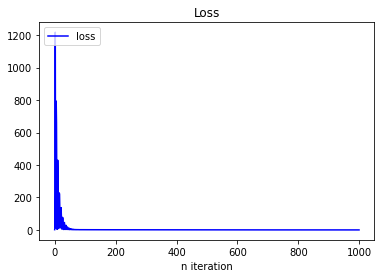

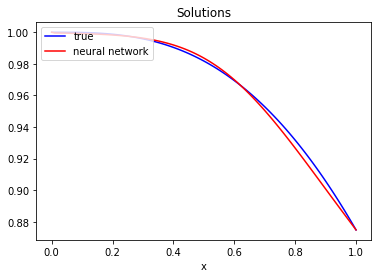

6.2824640533375735e-06


In [11]:
run_train(lr=0.03, num_e= 1000, isOn=True)

The running loss at 1 iteration is: 0.2610662196204867
The running loss at 2 iteration is: 59.94121684564872
The running loss at 3 iteration is: 1155.4659034817894
The running loss at 4 iteration is: 8.632044306954873
The running loss at 5 iteration is: 392.1565766238396
The running loss at 6 iteration is: 736.9623336451132
The running loss at 7 iteration is: 563.5753037582745
The running loss at 8 iteration is: 169.74956766307682
The running loss at 9 iteration is: 4.573914261749537
The running loss at 10 iteration is: 253.38389171100948
The running loss at 11 iteration is: 409.0936025781135
The running loss at 12 iteration is: 198.36010832692997
The running loss at 13 iteration is: 10.148580097103372
The running loss at 14 iteration is: 49.50918051967669
The running loss at 15 iteration is: 179.15191722181618
The running loss at 16 iteration is: 228.14720176190454
The running loss at 17 iteration is: 157.5774222984036
The running loss at 18 iteration is: 44.412772755307586
The runnin

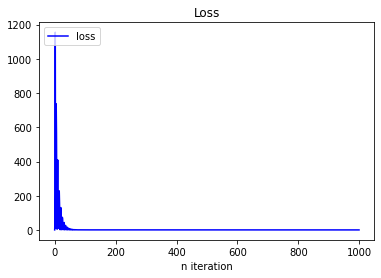

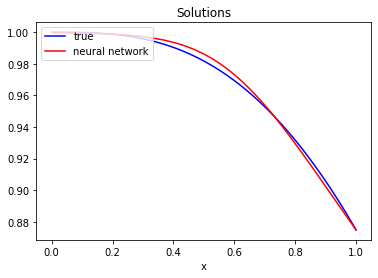

6.312356855829214e-06


In [22]:
run_train(lr=0.03, num_e= 1000, isOn=True)

Streaming output truncated to the last 5000 lines.
The running loss at 5001 iteration is: 0.14405010716623778
The running loss at 5002 iteration is: 0.14350172735056105
The running loss at 5003 iteration is: 0.14295176024687867
The running loss at 5004 iteration is: 0.14242444142731497
The running loss at 5005 iteration is: 0.1419756179543985
The running loss at 5006 iteration is: 0.14156057017644533
The running loss at 5007 iteration is: 0.14099168593547037
The running loss at 5008 iteration is: 0.14052688790028842
The running loss at 5009 iteration is: 0.14001026385542595
The running loss at 5010 iteration is: 0.1395489851413156
The running loss at 5011 iteration is: 0.13904773572598653
The running loss at 5012 iteration is: 0.13860258920530613
The running loss at 5013 iteration is: 0.13814504205602995
The running loss at 5014 iteration is: 0.13763353680399565
The running loss at 5015 iteration is: 0.13718974243126178
The running loss at 5016 iteration is: 0.1367013302282759
The runn

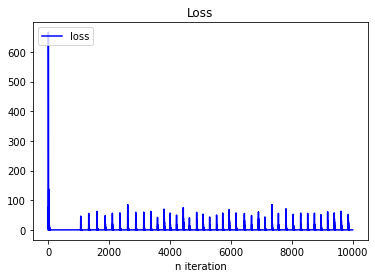

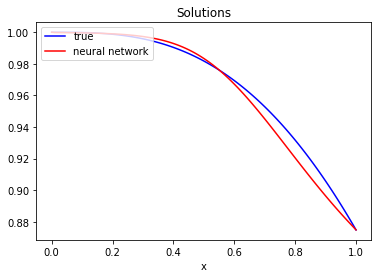

2.8813876647108546e-05


In [24]:
run_train(lr=0.03, num_e= 10000, isOn=True)

In [13]:
# from google.colab import drive
# drive.mount('/content/drive')

In [14]:
# save weights
# filepath = '/content/drive/My Drive/Colab Notebooks/Project_PINNs/weight_working_ex01.txt'
# torch.save(model.state_dict(), filepath)

In [15]:
# #Later to restore:
# model.load_state_dict(torch.load(filepath))
# model.eval()

In [16]:
def evaluate_np(x_data_np):
    u_hat = []
    for x in x_data_np:
        x_tensor = torch.tensor(np.array([x]), requires_grad= True)
        temp = model(x_tensor.float())
        u_hat.append(temp.clone().item())
        # u_hat = torch.hstack([u_hat, temp])
    return u_hat

In [17]:
def evaluate_error_np(x_data_np):
    y_pred = evaluate_np(x_data_np)
    y_true = u_star_func(x_data_np)
    return np.mean(np.square(y_true -  y_pred))

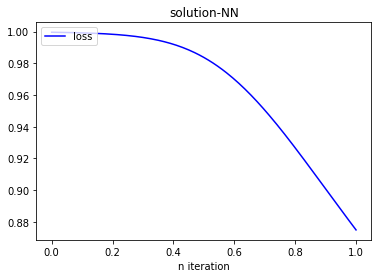

6.294729403435639e-06

In [18]:
x_init_np2 = np.arange(start=a, stop=b+step/2, step=step/2)
x_init2 = torch.tensor(x_init_np2, requires_grad= True)
# print(x_init)
# print(x_init2.shape)
y_pred2 = evaluate_np(x_init_np2)

draw_result(x_init_np2, y_pred2, 'solution-NN')
evaluate_error_np(x_init_np2)

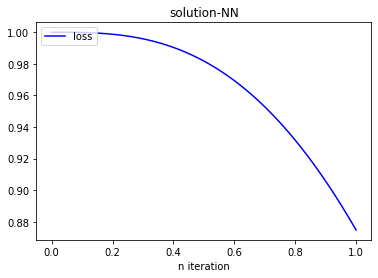

In [19]:
draw_result(x_init_np2, u_star_func(x_init_np2), 'solution-NN')

In [20]:
step_size = []
error = []
for k in [1,2,3,4,5,6,7]:
    x_vec = np.arange(start=a, stop=b+step/k, step=step/k)
    # x_vec_tensor = torch.tensor(x_vec, requires_grad= True)
    y_pred = evaluate_np(x_vec)
    error.append(evaluate_error_np(x_vec))
    step_size.append(step/k)

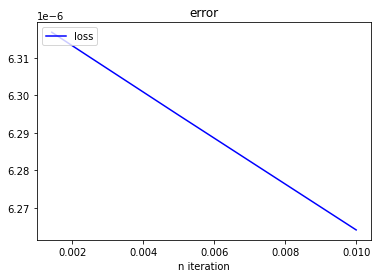

[0.01, 0.005, 0.0033333333333333335, 0.0025, 0.002, 0.0016666666666666668, 0.0014285714285714286]


In [21]:
draw_result(step_size[::-1], error[::-1], 'error')
print(step_size)

# Appendix: Understanding pytorch gradient

We create two vectors

$$a = \begin{bmatrix} {2\\3}
\end{bmatrix}, \qquad\text{and}\qquad b = \begin{bmatrix} {6\\4}
\end{bmatrix}$$

Let us consider the function

$$ Q(x,y) = 3x^3 - y^2$$

The convention here is that, if 
$$\mathbf{x} = \begin{bmatrix} {x_1\\x_2\\ \vdots\\ x_n}
\end{bmatrix} \qquad\text{and}\qquad \mathbf{y} = \begin{bmatrix} {y_1\\y_2\\ \vdots\\ y_n}
\end{bmatrix}$$
then
the action of $Q$ on $\mathbf{x}, \mathbf{y}$ are component-wise, i.e.,

$$ Q(\mathbf{x},\mathbf{y}) = \begin{bmatrix} {Q(x_1,y_1)\\ Q(x_2,y_2)\\ \vdots\\ Q(x_n,y_n)}
\end{bmatrix} $$

In `pytorch`, this is saved as a tensor object.